# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import seaborn as sns

# **Data Visualization**

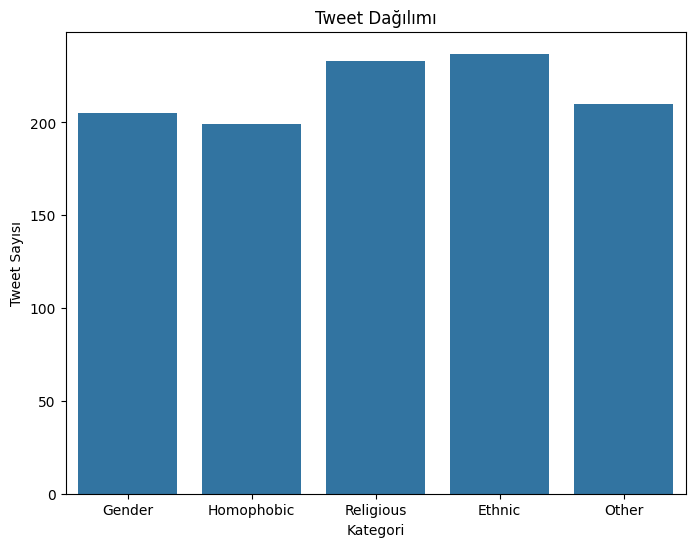

In [ ]:
# Verileri yükle
targets = pd.read_csv('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target based/all_targets/target_all_other.csv')
# Nefret içeren ve içermeyen tweet'lerin sayısını görselleştir
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=targets)
ax.set_title('Tweet Dağılımı')
ax.set_xlabel('Kategori')
ax.set_ylabel('Tweet Sayısı')
plt.xticks([0, 1,2,3,4], ['Gender', 'Homophobic','Religious','Ethnic','Other'])  # Etiket isimlerini belirtiniz
plt.show()

# **Normalization**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
# nltk kütüphanesinden Türkçe stop words yükleyelim
import nltk

def frekans(label,name):
    nltk.download('stopwords')
    turkish_stopwords = stopwords.words('turkish')

    # Nefret içeren tweet'leri filtrele
    nefret_tweets = targets[targets['label'] == label]['text']

    # En sık geçen kelimeleri say (Türkçe stop words ile)
    vectorizer = CountVectorizer(stop_words=turkish_stopwords, max_features=10)
    nefret_counts = vectorizer.fit_transform(nefret_tweets)
    sum_words = nefret_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Kelime frekanslarını çubuk grafikte göster
    words_df = pd.DataFrame(words_freq, columns=['word', 'count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=words_df)
    plt.title(f'Top-10 Most Common Unigrams in {name}-Based Hate Speech Text')
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


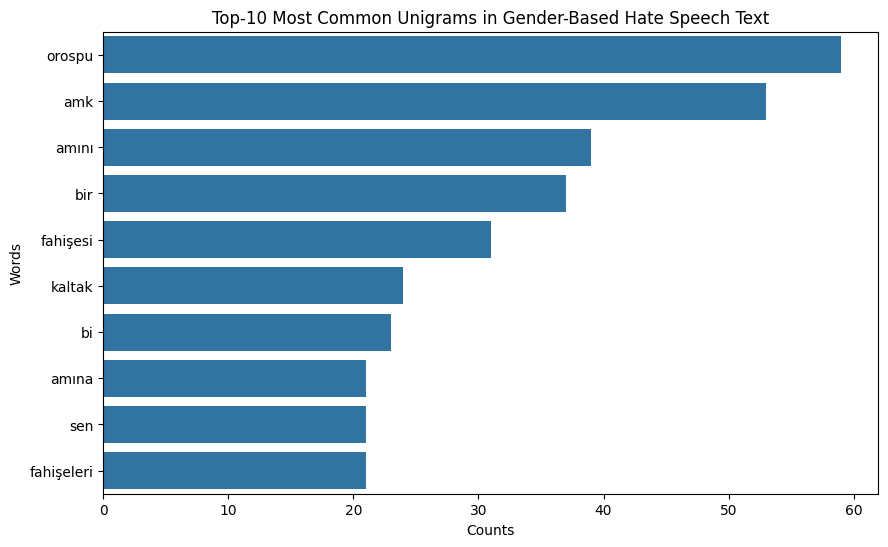

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


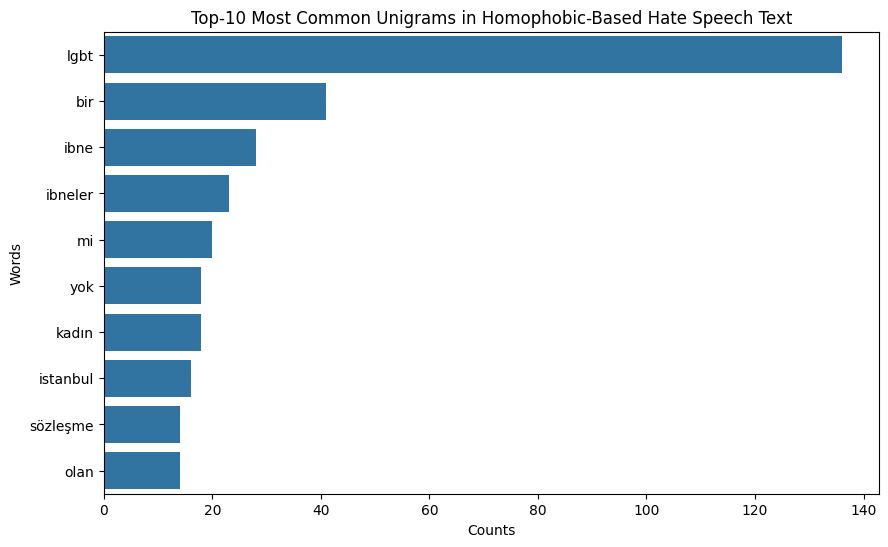

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


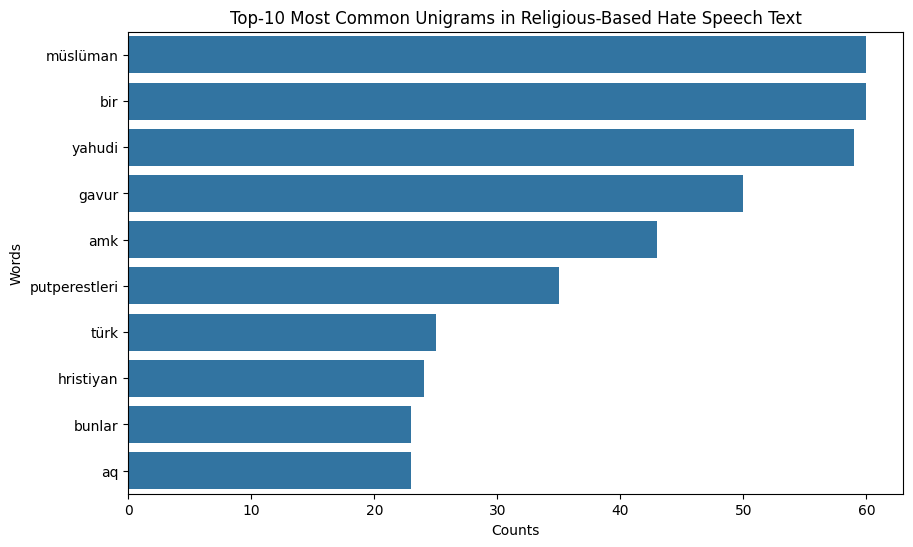

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


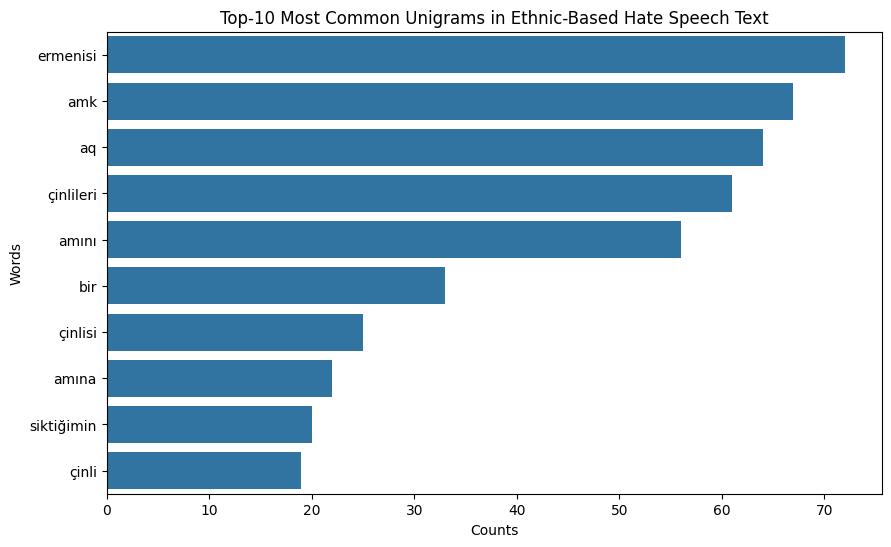

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


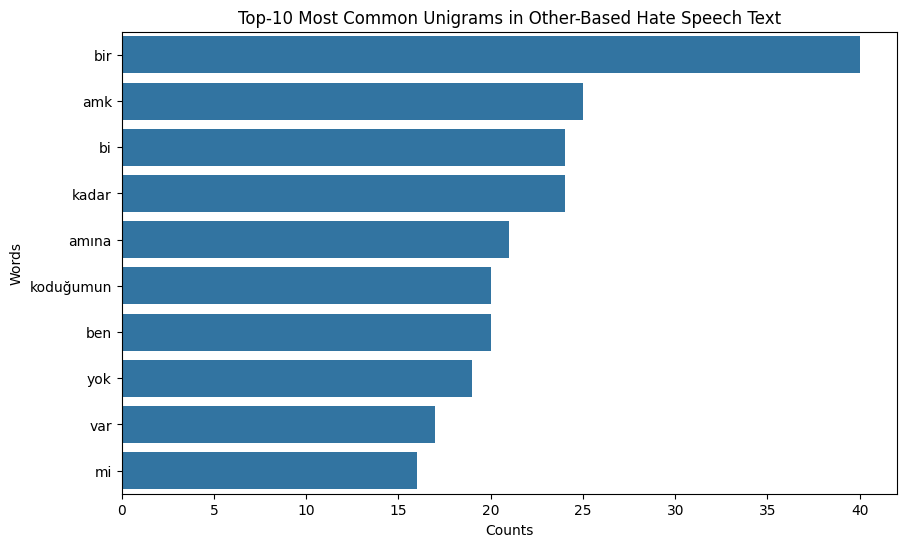

In [ ]:
import re

def normalize_text(text):
    #Kullanıcı adlarını kaldırır
    #text = re.sub(r'([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)','', text)

    text = re.sub(r'@\w+', '', text)
    # Tüm harfleri küçük harfe çevir (uncased model kullanılıyorsa)
    text = text.lower()

    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # HTML etiketlerini kaldır
    text = re.sub(r'<.*?>', '', text)

    # Noktalama işaretleri dışındaki özel karakterleri kaldır
    text = re.sub(r'[^a-zA-Z0-9ığüşöçİĞÜŞÖÇ\s]', '', text)

    # Ekstra boşlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()


    #Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern.sub(r' ', text)

    return text
targets['text'] = targets['text'].apply(normalize_text)
frekans(0,'Gender')
frekans(1,'Homophobic')
frekans(2,'Religious')
frekans(3,'Ethnic')
frekans(4,'Other')

# **Splitting Data Into Train, Test, Val**

In [ ]:
targets = targets.sample(frac=1, random_state=42).reset_index(drop=True)
# Veriyi eğitim, doğrulama ve test setlerine bölün
train_data, temp_data = train_test_split(targets, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
X_train=train_data['text']
y_train=train_data['label']
X_val=val_data['text']
y_val=val_data['label']
X_test = test_data['text']
y_test = test_data['label']

# **Load Model and Tokenizer**

In [ ]:
# Model ve tokenizer'ı yükleyin
model_name = "dbmdz/bert-base-turkish-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Tokenizasyon ve veri kümesini işleyin
def tokenize_function(tweets):
    return tokenizer(tweets, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Set Training Parameters and Start Training**

In [ ]:
!pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install accelerate -U

In [ ]:
!pip show accelerate

Name: accelerate
Version: 0.32.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
# PyTorch veri setlerini hazırla
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Define the compute_metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


train_dataset = TweetDataset(train_encodings, y_train.tolist())
val_dataset = TweetDataset(val_encodings, y_val.tolist())
# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
# Eğitim argümanlarını ayarla
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Trainer'ı kur ve eğitimi başlat
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.637262,0.851852,0.851373,0.864506,0.851852
2,No log,0.191887,0.925926,0.926356,0.927134,0.925926
3,No log,0.177665,0.944444,0.945058,0.946759,0.944444


TrainOutput(global_step=165, training_loss=0.5971125747218277, metrics={'train_runtime': 267.1597, 'train_samples_per_second': 9.736, 'train_steps_per_second': 0.618, 'total_flos': 684370288548864.0, 'train_loss': 0.5971125747218277, 'epoch': 3.0})

# **Testing The Model**

In [ ]:
# Modeli değerlendirin
test_dataset = TweetDataset(test_encodings, y_test.tolist())
metrics = trainer.evaluate(eval_dataset=test_dataset)
metrics

{'eval_loss': 0.16410759091377258,
 'eval_accuracy': 0.963302752293578,
 'eval_f1': 0.9634562415458259,
 'eval_precision': 0.9670959774170784,
 'eval_recall': 0.963302752293578,
 'eval_runtime': 3.0306,
 'eval_samples_per_second': 35.966,
 'eval_steps_per_second': 2.31,
 'epoch': 3.0}

# **Training with Classic ML Methods**

In [ ]:
# Veri vektörizasyonu
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Naive Bayes modeli
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)

# Logistic Regression modeli
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
lr_predictions = lr_model.predict(X_test_vec)

# Performans metriklerini yazdır
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.79      0.83      0.81        18
           2       0.61      0.88      0.72        25
           3       0.84      0.70      0.76        23
           4       0.46      0.29      0.35        21

    accuracy                           0.69       109
   macro avg       0.69      0.68      0.67       109
weighted avg       0.68      0.69      0.67       109

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65        22
           1       0.93      0.72      0.81        18
           2       0.86      0.76      0.81        25
           3       0.94      0.70      0.80        23
           4       0.46      0.90      0.61        21

    accuracy                           0.72       109
   macro avg       0.80      0.73      0.74       109

# **Save Model**

In [ ]:
# Modeli eğittikten sonra
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Modeli kaydetme
model.save_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_model_all')
tokenizer.save_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all')

('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all/tokenizer_config.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all/special_tokens_map.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all/vocab.txt',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all/added_tokens.json')

# **Load Model**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Model ve tokenizer'ı yükleyin
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_model_all')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all')

# Cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

TEST THE LOADED MODEL WİTH TEST DATASET

In [ ]:
from torch.utils.data import DataLoader
def compute_metrics(preds, labels):
    pred = np.array(preds)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Modeli değerlendirin
test_dataset = TweetDataset(test_encodings, y_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []


with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = np.argmax(logits.cpu().numpy(), axis=1)

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

metrics = compute_metrics(all_preds, all_labels)
print(metrics)

{'accuracy': 0.963302752293578, 'f1': 0.9634562415458259, 'precision': 0.9670959774170784, 'recall': 0.963302752293578}


# **Test Model**

In [ ]:
# Girdi metin
text = "bu lgbtli sapıklar hep bizi buluyor bunlar defolsun gitsin ibneler"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'bu lgbtli sapıklar hep bizi buluyor bunlar defolsun gitsin ibneler'
Model Tahmini: homophobic


In [ ]:
# Girdi metin
text = "suriyelileri sevenin amk hepsi orospu çocuğu siktirsinler kendi ülkelerine"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'suriyelileri sevenin amk hepsi orospu çocuğu siktirsinler kendi ülkelerine'
Model Tahmini: Ethnic


In [ ]:
# Girdi metin
text = "bu karılar böyle yollu hep işleri güçleri saçmalık aq"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'bu karılar böyle yollu hep işleri güçleri saçmalık aq'
Model Tahmini: gender


In [ ]:
# Girdi metin
text = "bu gavur ateistlerin kökünü kurutmak lazım"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'bu gavur ateistlerin kökünü kurutmak lazım'
Model Tahmini: Religious


In [ ]:
# Girdi metin
text = "orospu çocuğu gavurlar olmasa dünyamız daha iyi bi yer olurdu"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'orospu çocuğu gavurlar olmasa dünyamız daha iyi bi yer olurdu'
Model Tahmini: Religious


In [ ]:
# Girdi metin
text = "ülkemde mülteci istemiyorum"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'ülkemde mülteci istemiyorum'
Model Tahmini: Ethnic


In [ ]:
# Girdi metin
text = "bu ne saçma sapan bir iş ya ne yaptığınız belli değil asalaklar"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'bu ne saçma sapan bir iş ya ne yaptığınız belli değil asalaklar'
Model Tahmini: Other


In [ ]:
# Girdi metin
text = "yunan salakları boş konuşmayın"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4:'Other'}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'yunan salakları boş konuşmayın'
Model Tahmini: Ethnic
